# Описание проекта

Для эффективной работы промышленных предприятий необходима модель, предсказывающая коэффициент восстановления золота из золотосодержащей руды на технологических этапах.

# Описание данных
#### Технологический процесс:
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


#### Параметры этапов:
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


#### Наименование признаков
Наименование признаков должно быть такое:<br>
[этап].[тип_параметра].[название_параметра]<br>
Пример: rougher.input.feed_ag


#### Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

#### Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

***Данные индексируются датой и временем получения информации (признак date).***

***##Описание технологических процессов скрыто##***

In [1]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [3]:
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
# MAE - среднее абсолютное отклонение
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
 
# Оценка правильности
from sklearn.metrics import accuracy_score
# Разделение на тренировочную и валидационную выборку
from sklearn.model_selection import train_test_split
# Средняя квадратичная ошибка
from sklearn.metrics import mean_squared_error
# Оценка качества модели
from sklearn.metrics import classification_report
# Перебор параметров
from sklearn.model_selection import GridSearchCV
# classifier that makes predictions using simple rules
from sklearn.dummy import DummyClassifier


# Решающее дерево для регрессии
from sklearn.tree import DecisionTreeRegressor
# Случайный лес для регрессии 
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Для оформления 
bold_start = '\033[1m'
yellow = '\033[33m'
red = '\033[31m'
violet = '\033[35m'
blue = '\033[34m'
green = '\033[32m'
green_background = '\033[42m'
red_background = '\033[41m'
bold_end   = '\033[0m'

# 1. Подготовка данных

### 1.1. Откроем файлы и изучим их.

In [6]:
test = pd.read_csv('gold_recovery_test.csv', index_col=0)
train = pd.read_csv('gold_recovery_train.csv', index_col=0)
full = pd.read_csv('gold_recovery_full.csv', index_col=0)

In [7]:
test.index = pd.to_datetime(test.index, format='%Y-%m-%dT%H:%M:%S')
train.index = pd.to_datetime(train.index, format='%Y-%m-%dT%H:%M:%S')
full.index = pd.to_datetime(full.index, format='%Y-%m-%dT%H:%M:%S')

In [7]:
display(test.head(3))
display(test.info())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

None

In [8]:
display(train.head(3))
display(train.info())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

None

In [9]:
display(full.head())
display(full.info())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_c

None

Много пропусков. Как в целевых признаках, так и в обучающих

### 1.2. Проверим, что эффективность обогащения рассчитана правильно.

### Проверим расчет recovery в train:

- Вычислим recovery из сырых значений, проверим сколько из них совпало с предоставленными
- Вычислим MAE для рассчитанных значений и исходых

**Расчёт эффективности**

Эффективность обогащения рассчитывается по формуле:

$$recovery=\frac{C*(F-T)}{F*(C-T)}*100%$$
 
где:
- C — доля золота в концентрате после флотации/очистки;
    - 'rougher.output.concentrate_au'
- F — доля золота в сырье/концентрате до флотации/очистки;
    - 'rougher.input.feed_au'
- T — доля золота в отвальных хвостах после флотации/очистки.
    - 'rougher.output.tail_au'

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


In [10]:
display(train[train['rougher.output.concentrate_au'].isnull() == True].head(3))
display(train[train['rougher.output.concentrate_au'].isnull() == True].index)
display(train[train['rougher.output.concentrate_au'].isna() == True].head(3))
display(train[train['rougher.output.concentrate_au'].isna() == True].index)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-02-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DatetimeIndex(['2016-02-15 02:00:00', '2016-03-09 14:00:00',
               '2016-03-09 15:00:00', '2016-03-09 16:00:00',
               '2016-04-04 10:00:00', '2016-04-04 11:00:00',
               '2016-04-04 12:00:00', '2016-04-04 13:00:00',
               '2016-04-04 14:00:00', '2016-04-04 15:00:00',
               '2016-04-04 16:00:00', '2016-04-04 17:00:00',
               '2016-04-04 18:00:00', '2016-04-04 19:00:00',
               '2016-04-04 20:00:00', '2016-04-04 21:00:00',
               '2016-04-04 22:00:00', '2016-04-04 23:00:00',
               '2016-04-05 00:00:00', '2016-04-05 01:00:00',
               '2016-04-05 02:00:00', '2016-04-05 03:00:00',
               '2016-04-05 04:00:00', '2016-04-05 05:00:00',
               '2016-04-05 06:00:00', '2016-04-05 07:00:00',
               '2016-04-05 08:00:00', '2016-04-05 09:00:00',
               '2016-04-05 10:00:00', '2016-04-05 11:00:00',
               '2016-04-05 12:00:00', '2016-04-05 13:00:00',
               '2016-04-

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-02-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DatetimeIndex(['2016-02-15 02:00:00', '2016-03-09 14:00:00',
               '2016-03-09 15:00:00', '2016-03-09 16:00:00',
               '2016-04-04 10:00:00', '2016-04-04 11:00:00',
               '2016-04-04 12:00:00', '2016-04-04 13:00:00',
               '2016-04-04 14:00:00', '2016-04-04 15:00:00',
               '2016-04-04 16:00:00', '2016-04-04 17:00:00',
               '2016-04-04 18:00:00', '2016-04-04 19:00:00',
               '2016-04-04 20:00:00', '2016-04-04 21:00:00',
               '2016-04-04 22:00:00', '2016-04-04 23:00:00',
               '2016-04-05 00:00:00', '2016-04-05 01:00:00',
               '2016-04-05 02:00:00', '2016-04-05 03:00:00',
               '2016-04-05 04:00:00', '2016-04-05 05:00:00',
               '2016-04-05 06:00:00', '2016-04-05 07:00:00',
               '2016-04-05 08:00:00', '2016-04-05 09:00:00',
               '2016-04-05 10:00:00', '2016-04-05 11:00:00',
               '2016-04-05 12:00:00', '2016-04-05 13:00:00',
               '2016-04-

In [11]:
display(train[train['rougher.input.feed_au'].isnull() == True].head(3))
display(train[train['rougher.input.feed_au'].isnull() == True].index)
display(train[train['rougher.input.feed_au'].isna() == True].head(3))
display(train[train['rougher.input.feed_au'].isna() == True].index)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-02-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DatetimeIndex(['2016-02-15 02:00:00', '2016-03-09 14:00:00',
               '2016-03-09 15:00:00', '2016-03-09 16:00:00',
               '2016-04-04 10:00:00', '2016-04-04 11:00:00',
               '2016-04-04 12:00:00', '2016-04-04 13:00:00',
               '2016-04-04 14:00:00', '2016-04-04 15:00:00',
               '2016-04-04 16:00:00', '2016-04-04 17:00:00',
               '2016-04-04 18:00:00', '2016-04-04 19:00:00',
               '2016-04-04 20:00:00', '2016-04-04 21:00:00',
               '2016-04-04 22:00:00', '2016-04-04 23:00:00',
               '2016-04-05 00:00:00', '2016-04-05 01:00:00',
               '2016-04-05 02:00:00', '2016-04-05 03:00:00',
               '2016-04-05 04:00:00', '2016-04-05 05:00:00',
               '2016-04-05 06:00:00', '2016-04-05 07:00:00',
               '2016-04-05 08:00:00', '2016-04-05 09:00:00',
               '2016-04-05 10:00:00', '2016-04-05 11:00:00',
               '2016-04-05 12:00:00', '2016-04-05 13:00:00',
               '2016-04-

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-02-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DatetimeIndex(['2016-02-15 02:00:00', '2016-03-09 14:00:00',
               '2016-03-09 15:00:00', '2016-03-09 16:00:00',
               '2016-04-04 10:00:00', '2016-04-04 11:00:00',
               '2016-04-04 12:00:00', '2016-04-04 13:00:00',
               '2016-04-04 14:00:00', '2016-04-04 15:00:00',
               '2016-04-04 16:00:00', '2016-04-04 17:00:00',
               '2016-04-04 18:00:00', '2016-04-04 19:00:00',
               '2016-04-04 20:00:00', '2016-04-04 21:00:00',
               '2016-04-04 22:00:00', '2016-04-04 23:00:00',
               '2016-04-05 00:00:00', '2016-04-05 01:00:00',
               '2016-04-05 02:00:00', '2016-04-05 03:00:00',
               '2016-04-05 04:00:00', '2016-04-05 05:00:00',
               '2016-04-05 06:00:00', '2016-04-05 07:00:00',
               '2016-04-05 08:00:00', '2016-04-05 09:00:00',
               '2016-04-05 10:00:00', '2016-04-05 11:00:00',
               '2016-04-05 12:00:00', '2016-04-05 13:00:00',
               '2016-04-

In [12]:
display(train[train['rougher.output.tail_au'].isnull() == True].head(3))
display(train[train['rougher.output.tail_au'].isnull() == True].index)
display(train[train['rougher.output.tail_au'].isna() == True].head(3))
display(train[train['rougher.output.tail_au'].isna() == True].index)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-19 03:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,2.116168,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
2016-01-19 04:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301
2016-01-19 05:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,13.943929,-799.600659,12.040238,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819


DatetimeIndex(['2016-01-19 03:00:00', '2016-01-19 04:00:00',
               '2016-01-19 05:00:00', '2016-01-19 06:00:00',
               '2016-01-19 07:00:00', '2016-01-19 08:00:00',
               '2016-01-19 09:00:00', '2016-01-19 10:00:00',
               '2016-01-19 11:00:00', '2016-01-19 12:00:00',
               ...
               '2018-08-07 16:59:59', '2018-08-07 17:59:59',
               '2018-08-07 18:59:59', '2018-08-07 19:59:59',
               '2018-08-07 23:59:59', '2018-08-08 00:59:59',
               '2018-08-08 01:59:59', '2018-08-08 02:59:59',
               '2018-08-08 03:59:59', '2018-08-10 17:59:59'],
              dtype='datetime64[ns]', name='date', length=2249, freq=None)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-19 03:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,2.116168,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
2016-01-19 04:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301
2016-01-19 05:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,13.943929,-799.600659,12.040238,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819


DatetimeIndex(['2016-01-19 03:00:00', '2016-01-19 04:00:00',
               '2016-01-19 05:00:00', '2016-01-19 06:00:00',
               '2016-01-19 07:00:00', '2016-01-19 08:00:00',
               '2016-01-19 09:00:00', '2016-01-19 10:00:00',
               '2016-01-19 11:00:00', '2016-01-19 12:00:00',
               ...
               '2018-08-07 16:59:59', '2018-08-07 17:59:59',
               '2018-08-07 18:59:59', '2018-08-07 19:59:59',
               '2018-08-07 23:59:59', '2018-08-08 00:59:59',
               '2018-08-08 01:59:59', '2018-08-08 02:59:59',
               '2018-08-08 03:59:59', '2018-08-10 17:59:59'],
              dtype='datetime64[ns]', name='date', length=2249, freq=None)

In [13]:
display(train[train['rougher.output.recovery'].isnull() == True].head(3))
display(train[train['rougher.output.recovery'].isnull() == True].index)
display(train[train['rougher.output.recovery'].isna() == True].head(3))
display(train[train['rougher.output.recovery'].isna() == True].index)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-17 05:00:00,5.919503,11.078044,6.215769,42.922611,71.308281,10.866006,1.577753,17.550397,2.47628,137.334448,...,13.972224,-548.238797,12.042964,-550.430774,9.989624,-499.606754,7.950446,-500.352648,12.011728,-599.043399
2016-01-19 03:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,2.116168,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
2016-01-19 04:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,NaN,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301


DatetimeIndex(['2016-01-17 05:00:00', '2016-01-19 03:00:00',
               '2016-01-19 04:00:00', '2016-01-19 05:00:00',
               '2016-01-19 06:00:00', '2016-01-19 07:00:00',
               '2016-01-19 08:00:00', '2016-01-19 09:00:00',
               '2016-01-19 10:00:00', '2016-01-19 11:00:00',
               ...
               '2018-08-08 03:59:59', '2018-08-09 14:59:59',
               '2018-08-09 20:59:59', '2018-08-09 21:59:59',
               '2018-08-10 17:59:59', '2018-08-11 16:59:59',
               '2018-08-11 17:59:59', '2018-08-11 18:59:59',
               '2018-08-11 19:59:59', '2018-08-11 20:59:59'],
              dtype='datetime64[ns]', name='date', length=2573, freq=None)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-17 05:00:00,5.919503,11.078044,6.215769,42.922611,71.308281,10.866006,1.577753,17.550397,2.47628,137.334448,...,13.972224,-548.238797,12.042964,-550.430774,9.989624,-499.606754,7.950446,-500.352648,12.011728,-599.043399
2016-01-19 03:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,2.116168,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
2016-01-19 04:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.00000,NaN,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301


DatetimeIndex(['2016-01-17 05:00:00', '2016-01-19 03:00:00',
               '2016-01-19 04:00:00', '2016-01-19 05:00:00',
               '2016-01-19 06:00:00', '2016-01-19 07:00:00',
               '2016-01-19 08:00:00', '2016-01-19 09:00:00',
               '2016-01-19 10:00:00', '2016-01-19 11:00:00',
               ...
               '2018-08-08 03:59:59', '2018-08-09 14:59:59',
               '2018-08-09 20:59:59', '2018-08-09 21:59:59',
               '2018-08-10 17:59:59', '2018-08-11 16:59:59',
               '2018-08-11 17:59:59', '2018-08-11 18:59:59',
               '2018-08-11 19:59:59', '2018-08-11 20:59:59'],
              dtype='datetime64[ns]', name='date', length=2573, freq=None)

создадим наш столбец с подсчитанным 𝑟𝑒𝑐𝑜𝑣𝑒𝑟𝑦 и сравним с исходным

In [14]:
c,f,t = train['rougher.output.concentrate_au'], train['rougher.input.feed_au'],train['rougher.output.tail_au'] 
    
numerator = (c*(f-t))
denominator =(f*(c-t))   
rec = numerator / denominator * 100

train['recovery'] =  rec  

recovery не может быть меньше 0 и больше 100, пока заменим эти значения на 0

In [15]:
display(train.query('recovery < 0 ')['recovery'].head(3))
display(train.query('recovery > 100 ')['recovery'].head(3))

date
2016-01-30 12:00:00   -3913.312866
2016-01-30 17:00:00    -116.312118
2016-02-07 08:00:00      -1.086185
Name: recovery, dtype: float64

date
2016-01-17 05:00:00    188.742102
2016-02-18 19:00:00    113.796771
2016-02-18 21:00:00    106.088867
Name: recovery, dtype: float64

In [16]:
train['recovery'].isna().sum()

2283

In [17]:
train[train['recovery'] > 100]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-17 05:00:00,5.919503,11.078044,6.215769,42.922611,71.308281,10.866006,1.577753,17.550397,2.476280,137.334448,...,-548.238797,12.042964,-550.430774,9.989624,-499.606754,7.950446,-500.352648,12.011728,-599.043399,188.742102
2016-02-18 19:00:00,8.614695,11.036873,10.336875,36.928462,78.126966,13.149458,2.420853,9.400427,3.214122,218.399581,...,-278.864227,22.036013,-241.572594,25.013616,-399.018151,20.992585,-507.308317,28.709612,-409.435414,113.796771
2016-02-18 21:00:00,9.345421,11.418294,11.162511,33.653462,79.990029,13.226297,2.633671,9.500873,3.161041,226.803999,...,-401.198447,23.904554,-399.900174,24.971564,-402.532220,20.984770,-400.214263,29.980310,-400.994173,106.088867
2016-04-09 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,5.691545,1.748094,12.233276,3.659829,79.659210,...,-469.312814,14.039845,-275.078589,11.969535,-488.465445,9.958567,-728.091840,19.943176,-499.413923,630.489449
2016-04-10 08:00:00,7.687253,12.471182,9.294314,37.635658,52.989622,6.857509,1.916810,13.262433,3.690591,99.200019,...,-501.260121,14.016206,-397.286321,9.970836,-499.913898,12.064607,-799.581138,15.974000,-500.491895,108.559127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-04 12:59:59,4.280694,8.270860,9.593037,46.394797,62.269862,17.305340,5.451323,9.051423,4.603845,211.530304,...,-418.148356,17.051658,-187.367496,16.991056,-504.398198,13.008057,-500.551230,17.972461,-509.091379,100.538404
2018-08-09 14:59:59,5.254418,10.012572,9.057546,43.792483,77.295186,15.809390,4.240217,10.581050,2.893630,210.186782,...,-500.777631,23.007315,-500.223186,22.957606,-498.647551,18.028632,-500.070522,22.985224,-532.333301,100.485526
2018-08-09 20:59:59,5.612596,9.482001,9.216730,43.791172,73.685150,17.176448,4.430130,8.911966,3.377770,202.640327,...,-500.825139,23.035288,-499.657723,22.987704,-496.798853,18.006847,-499.644334,23.006721,-564.919489,6343.566718


In [18]:
def fill(row):
    if row['recovery'] > 100:
        return 0
    return row['recovery']

train['recovery'] = train.apply(fill, axis=1)

In [19]:
train[train['recovery'] < 0]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-30 12:00:00,0.504139,1.097509,0.950549,4.304974,NaN,0.650137,0.105681,1.001118,0.164934,178.286623,...,-498.931079,12.923143,-502.597095,14.005161,-502.480686,13.997617,-499.814314,15.999909,-500.497284,-3913.312866
2016-01-30 17:00:00,12.057372,5.933298,NaN,36.597453,NaN,7.423259,2.750497,12.908152,7.723369,NaN,...,-500.014744,0.000028,-502.436744,-0.240355,-499.284554,0.638377,-500.057003,0.224307,-499.506741,-116.312118
2016-02-07 08:00:00,5.103569,10.011828,1.973886,45.273819,NaN,10.923920,1.590531,15.898159,2.384391,101.176937,...,-500.903275,16.002653,-499.172818,17.936302,-500.389766,15.965873,-500.109413,18.017655,-500.160353,-1.086185
2016-02-13 04:00:00,3.918705,6.522631,NaN,22.925720,30.121080,0.944392,0.082820,1.472282,0.177436,11.103131,...,-398.930907,21.988250,-399.744140,22.946714,-397.662961,21.026679,-399.657635,25.035264,-400.027717,-112789.873301
2016-02-17 20:00:00,6.690376,10.442621,NaN,41.625311,NaN,11.699671,1.571995,5.459241,3.643600,21.816651,...,-499.835647,16.052666,-500.101662,16.015423,-498.998513,12.016094,-500.056476,26.985248,-500.124832,-78.434804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-07 22:59:59,0.354655,0.531568,0.621536,2.168631,100.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,-502.614591,23.069446,-500.063525,23.014892,-544.751277,18.025273,-500.463749,23.002909,-536.657793,-68360.243330
2018-08-09 21:59:59,5.169353,9.136804,8.717351,45.464599,73.397127,16.364564,4.456966,8.784155,3.218146,197.944501,...,-501.259633,23.018737,-500.180836,23.000203,-503.658183,17.996658,-500.423997,23.023790,-534.375371,-0.654679
2018-08-11 18:59:59,3.725068,8.274357,8.841145,48.654627,49.317741,16.118560,5.002483,10.102624,5.733715,222.410319,...,-501.346407,20.033370,-500.583932,17.968434,-501.021691,12.960565,-500.076888,17.994091,-504.227412,-0.482567


In [20]:
def fill(row):
    if row['recovery'] < 0:
        return 0
    return row['recovery']

train['recovery'] = train.apply(fill, axis=1)

In [21]:
train['recovery'].describe()

count    14577.000000
mean        80.755022
std         18.861606
min         -0.000000
25%         79.406823
50%         85.037681
75%         90.034560
max        100.000000
Name: recovery, dtype: float64

In [22]:
right_recovery_sum = np.isclose(train['rougher.output.recovery'], train['recovery']).sum()
right_recovery_sum, train.shape[0]-right_recovery_sum

(14287, 2573)

In [23]:
train['recovery'].isna().sum()

2283

In [24]:
train['rougher.output.recovery'].isna().sum()

2573

Заполним несовпавшие значения *_0_* , поскольку они, скорее всего, тянут NaN из агрументов формулы , потому что на выходе **recovery** есть *NaN*

In [25]:
def percent(train,n):
    na_info = (train.isna() | train.isnull()).sum()
    nan = pd.concat([na_info / train.shape[0], na_info], axis=1,  keys=['percent', 'ount'])
    nan['percent'] = nan['percent']*100
    print(violet, nan.sort_values('percent', ascending=False).head(n), bold_end)

In [26]:
percent(train,6)

                                      percent  ount
rougher.output.recovery            15.260973  2573
recovery                           13.540925  2283
rougher.output.tail_ag             13.345196  2250
rougher.output.tail_sol            13.339265  2249
rougher.output.tail_au             13.339265  2249
secondary_cleaner.output.tail_sol  11.779359  1986 


In [27]:
len(test.columns)

52

In [28]:
percent(test,5)

                                      percent  ount
rougher.input.floatbank11_xanthate  6.028005   353
primary_cleaner.input.sulfate       5.157104   302
primary_cleaner.input.depressant    4.849727   284
rougher.input.floatbank10_sulfate   4.388661   257
primary_cleaner.input.xanthate      2.834699   166 


До заполнения NaN rougher.output.recovery и recovery имеют большую долю пропусков

Пропуски в тесте незначительны

Пропуски в трейне более значитиельны, большая часть из них в целевых признаках .output., так же в rougher.output.recovery пропусков 2573 

In [29]:
mean_absolute_error(train['rougher.output.recovery'].interpolate(method='time'),
                    train['recovery'].interpolate(method='time'))

4.263918518173849

При заполнении пропусков методом интерпаляции средняя абсолютная ошибка получилась слишком высокой. Все таки эти пропуски ближе к 0, чем к интерполируемому числу

In [30]:
mean_absolute_error(train['rougher.output.recovery'].fillna(method='ffill'),
                    train['recovery'].fillna(method='ffill'))

5.007071668971944

In [31]:
train['recovery'] = train['recovery'].fillna(0)
train['rougher.output.recovery'] = train['rougher.output.recovery'].fillna(0)

### MAE

In [32]:
mean_absolute_error(train['rougher.output.recovery'], train['recovery'])

8.00350954615662e-15

---

In [33]:
# c = pd.Series(train['rougher.output.concentrate_au'])
# f = pd.Series(train['rougher.input.feed_au'])
# t = pd.Series(train['rougher.output.tail_au'])

In [34]:
# c

date
2016-01-15 00:00:00    19.793808
2016-01-15 01:00:00    20.050975
2016-01-15 02:00:00    19.737170
2016-01-15 03:00:00    19.320810
2016-01-15 04:00:00    19.216101
                         ...    
2018-08-18 06:59:59    18.603550
2018-08-18 07:59:59    18.441436
2018-08-18 08:59:59    15.111231
2018-08-18 09:59:59    17.834772
2018-08-18 10:59:59    17.804134
Name: rougher.output.concentrate_au, Length: 16860, dtype: float64

In [35]:
# c = train['rougher.output.concentrate_au']
# f = train['rougher.input.feed_au']
# t = train['rougher.output.tail_au']

# ddd = (c*(f-t)) / ((f(c-t))) * 100

# mae = (train['rougher.output.recovery'] - ddd).abs().mean()
# print("MAE между данными и расчетами:", mae)

---

Средняя абсолютная ошибка получилась маленькой, поэтому считаем что ***recovery*** **посчитан верно**

In [36]:
percent(train,6)

                                       percent  ount
rougher.output.tail_ag              13.345196  2250
rougher.output.tail_au              13.339265  2249
rougher.output.tail_sol             13.339265  2249
secondary_cleaner.output.tail_sol   11.779359  1986
rougher.input.floatbank11_xanthate  11.293001  1904
final.output.recovery                9.021352  1521 


In [37]:
percent(test,6)

                                      percent  ount
rougher.input.floatbank11_xanthate  6.028005   353
primary_cleaner.input.sulfate       5.157104   302
primary_cleaner.input.depressant    4.849727   284
rougher.input.floatbank10_sulfate   4.388661   257
primary_cleaner.input.xanthate      2.834699   166
rougher.input.floatbank10_xanthate  2.100410   123 


### 1.3. Проанализируем признаки, недоступные в тестовой выборке.

В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к. их невозможно получить/измерить во время выполнения технологического процесса. 

In [38]:
del_list = list(set(train.columns) - set(test.columns))
del_list

['primary_cleaner.output.concentrate_au',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'final.output.tail_ag',
 'recovery',
 'rougher.output.tail_pb',
 'final.output.concentrate_ag',
 'primary_cleaner.output.tail_sol',
 'final.output.concentrate_sol',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_sol',
 'secondary_cleaner.output.tail_pb',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'secondary_cleaner.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.concentrate_au',
 'final.output.concentrate_pb',
 'secondary_cleaner.output.tail_au',
 'rougher.calculation.au_pb_ratio',
 'secondary_cleaner.output.tail_ag',
 'rougher.output.recovery',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.

Разница в отсутствии целевого признака *output* в **test**

Так же в **test** нет признаков *calculation (расчётные характеристики)* для этапа *rougher (флотация)*, видимо эти данные рассчитываются позднее и не доступны во время процесса.

### 1.4. Предобработка данных.

Проверим столбцы train, test в full по индексам

In [39]:
train_root = train.drop(['recovery'], axis=1)
train_root.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [40]:
train_root_in_full = full[list(set(train_root.columns))]
train_root_in_full.head(3)

,rougher.input.feed_pb,rougher.calculation.floatbank10_sulfate_to_au_feed,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank5_a_air,primary_cleaner.output.concentrate_sol,rougher.output.tail_au,final.output.concentrate_pb,rougher.output.concentrate_au,secondary_cleaner.output.tail_ag,...,primary_cleaner.state.floatbank8_b_level,rougher.calculation.au_pb_ratio,rougher.output.recovery,primary_cleaner.output.tail_ag,primary_cleaner.input.feed_size,final.output.tail_pb,final.output.tail_au,primary_cleaner.output.concentrate_pb,rougher.state.floatbank10_c_level,primary_cleaner.output.tail_au
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,2.284912,3481.779053,-605.841980,-502.488007,9.925633,19.529297,1.170244,9.889648,19.793808,14.500184,...,-516.403442,2.838687,87.107763,14.936526,7.25,0.895447,2.143149,10.389648,-442.204468,2.106679
2016-01-15 01:00:00,2.266033,3498.370979,-599.787184,-505.503262,10.039245,19.369147,1.184827,9.968944,20.050975,14.265474,...,-499.865889,2.858998,86.843261,16.250511,7.25,0.927452,2.224930,10.497069,-449.830646,2.353017
2016-01-15 02:00:00,2.159622,3495.348910,-601.427363,-502.520901,10.070913,19.167579,1.162562,10.213995,19.737170,14.115662,...,-500.607762,2.945989,86.842308,16.491823,7.25,0.953716,2.257889,10.354494,-449.954491,2.416800


In [41]:
test_in_full = full[list(set(test.columns))]
test_in_full.head(3)

,rougher.input.feed_ag,rougher.input.feed_sol,rougher.input.feed_pb,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank2_b_air,rougher.input.floatbank11_sulfate,secondary_cleaner.state.floatbank4_b_air,primary_cleaner.state.floatbank8_a_level,rougher.state.floatbank10_a_level,rougher.state.floatbank10_e_air,...,rougher.state.floatbank10_c_level,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_c_air,rougher.input.feed_size,primary_cleaner.state.floatbank8_a_air,secondary_cleaner.state.floatbank6_a_air,rougher.input.feed_rate,rougher.state.floatbank10_d_air,secondary_cleaner.state.floatbank5_a_level,primary_cleaner.state.floatbank8_d_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,36.808594,2.284912,23.961798,23.893660,11.836743,12.099931,-498.912140,-404.066986,1404.472046,...,-442.204468,0.988759,1549.873901,55.486599,1549.775757,14.151341,523.546326,1598.937256,-498.310211,-493.428131
2016-01-15 01:00:00,6.161113,35.753385,2.266033,23.970550,23.889530,11.996163,11.950531,-500.904965,-400.065196,1399.227084,...,-449.830646,1.002663,1575.994189,57.278666,1576.166671,13.998353,525.290581,1600.527589,-500.169983,-498.931665
2016-01-15 02:00:00,6.116455,35.971630,2.159622,23.913535,23.886657,11.920305,11.912783,-499.997791,-400.074028,1399.180945,...,-449.954491,0.991265,1602.003542,57.510649,1601.556163,14.028663,530.026610,1599.849325,-500.129135,-499.827444


In [42]:
prepared_train = train_root_in_full.loc[train.index]

prepared_test = test_in_full.loc[test.index]

In [43]:
print(bold_start,blue,'Пропуски в full по столбцам train',bold_end)
print(prepared_train.isna().sum())
print(red, '==='*20, bold_end)
print(bold_start,blue,'Доля пропусков full по столбцам train',bold_end)
print(percent(prepared_train,len(prepared_train.columns)))
        
print(bold_start,violet, 'сравним с:', bold_end)
print(percent(train,len(train.columns)), bold_end)

  Пропуски в full по столбцам train 
rougher.input.feed_pb                                 228
rougher.calculation.floatbank10_sulfate_to_au_feed     27
secondary_cleaner.state.floatbank6_a_level             85
secondary_cleaner.state.floatbank4_a_level            113
secondary_cleaner.state.floatbank5_a_air               85
                                                     ... 
final.output.tail_pb                                  183
final.output.tail_au                                   66
primary_cleaner.output.concentrate_pb                 358
rougher.state.floatbank10_c_level                      46
primary_cleaner.output.tail_au                         83
Length: 86, dtype: int64
  Доля пропусков full по столбцам train 
                                                       percent  ount
rougher.output.recovery                             15.260973  2573
rougher.output.tail_ag                              13.345196  2250
rougher.output.tail_sol                             13

In [44]:
print(bold_start,blue,'Пропуски в full по столбцам test',bold_end)
print(prepared_test.isna().sum())
print(red, '==='*20, bold_end)
print(bold_start,blue,'Доля пропусков full по столбцам test',bold_end)
print(percent(prepared_test,len(prepared_test.columns)))

print(bold_start,violet, 'сравним с:', bold_end)
print(percent(test,len(test.columns)), bold_end)

  Пропуски в full по столбцам test 
rougher.input.feed_ag                          16
rougher.input.feed_sol                         67
rougher.input.feed_pb                          16
secondary_cleaner.state.floatbank3_a_air       34
secondary_cleaner.state.floatbank2_b_air       23
rougher.input.floatbank11_sulfate              55
secondary_cleaner.state.floatbank4_b_air       16
primary_cleaner.state.floatbank8_a_level       16
rougher.state.floatbank10_a_level              16
rougher.state.floatbank10_e_air                17
rougher.state.floatbank10_b_level              16
secondary_cleaner.state.floatbank6_a_level     16
secondary_cleaner.state.floatbank4_a_level     16
rougher.state.floatbank10_b_air                17
rougher.state.floatbank10_f_air                17
rougher.input.feed_au                          16
secondary_cleaner.state.floatbank2_b_level     16
primary_cleaner.state.floatbank8_b_air         16
secondary_cleaner.state.floatbank5_a_air       16
primary_cleane

обратим внимание, что в full по столбцам test и train одниаковые доли пропусков, поэтому из full возьмем только целевой признак 

И заполним все пропуски, видимо, самым оптимальным методом: ffill

In [45]:
prepared_full = full
prepared_full = prepared_full.dropna(subset=['final.output.recovery'])
prepared_full = prepared_full.dropna(subset=['rougher.output.recovery'])

In [46]:
prepared_full = prepared_full.fillna(method='ffill')

# 2. Анализ данных

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка


In [48]:
X_train = train[test.columns]
X_train.columns.str.contains('primary_cleaner')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [49]:
X_train = train[test.columns]
X_train.columns.str.contains('secondary_cleaner')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [50]:
X_train = train[test.columns]

#Все столбцы с rougher в названии найдем через 'фильтр' .str.contains
rougher_cols = X_train.columns.str.contains('rougher')
X_train_rougher = X_train.loc[:, rougher_cols]
X_test_rougher = test.loc[:, rougher_cols]

y_train_rougher = train[['rougher.output.tail_au', 'rougher.output.concentrate_au']]

primary_cleaner_cols = X_train.columns.str.contains('primary_cleaner')
X_train_primary_cleaner = X_train.loc[:, primary_cleaner_cols]
X_test_primary_cleaner = test.loc[:, primary_cleaner_cols]
y_train_primary_cleaner = train[['final.output.tail_au', 'final.output.concentrate_au']]

secondary_cleaner_cols = X_train.columns.str.contains('secondary_cleaner')
X_train_secondary_cleaner = X_train.loc[:, secondary_cleaner_cols]
X_test_secondary_cleaner = test.loc[:, secondary_cleaner_cols]
y_train_secondary_cleaner = train[['final.output.tail_au', 'final.output.concentrate_au']]

In [51]:
train[test.columns].loc[:, train[test.columns].columns.str.contains('rougher.input.feed')]

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au
date,,,,,,
2016-01-15 00:00:00,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150
2016-01-15 01:00:00,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583
2016-01-15 02:00:00,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222
2016-01-15 03:00:00,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189
2016-01-15 04:00:00,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707
...,...,...,...,...,...,...
2018-08-18 06:59:59,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862
2018-08-18 07:59:59,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619
2018-08-18 08:59:59,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061


In [52]:
rougher_input_feed = train[{'rougher.input.feed_au',
                            'rougher.input.feed_ag',
                            'rougher.input.feed_pb'
                           }]


rougher_output_concentrate = train[{'rougher.output.concentrate_au',
                                    'rougher.output.concentrate_ag',
                                    'rougher.output.concentrate_pb'
                                   }]

primary_cleaner_output_concentrate = train[{'primary_cleaner.output.concentrate_au',
                                            'primary_cleaner.output.concentrate_ag',
                                            'primary_cleaner.output.concentrate_pb'
                                           }]

final_output_concentrate = train[{'final.output.concentrate_au',
                                  'final.output.concentrate_ag',
                                  'final.output.concentrate_pb'}]


display(rougher_input_feed.head())
display(rougher_output_concentrate.head())
display(primary_cleaner_output_concentrate.head())
display(final_output_concentrate.head())

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au
date,,,
2016-01-15 00:00:00,6.100378,2.284912,6.486150
2016-01-15 01:00:00,6.161113,2.266033,6.478583
2016-01-15 02:00:00,6.116455,2.159622,6.362222
2016-01-15 03:00:00,6.043309,2.037807,6.118189
2016-01-15 04:00:00,6.060915,1.786875,5.663707


,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au
date,,,
2016-01-15 00:00:00,11.500771,7.101074,19.793808
2016-01-15 01:00:00,11.615865,7.278807,20.050975
2016-01-15 02:00:00,11.695753,7.216833,19.737170
2016-01-15 03:00:00,11.915047,7.175616,19.320810
2016-01-15 04:00:00,12.411054,7.240205,19.216101


,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag
date,,,
2016-01-15 00:00:00,10.389648,34.174427,8.547551
2016-01-15 01:00:00,10.497069,34.118526,8.558743
2016-01-15 02:00:00,10.354494,33.969464,8.603505
2016-01-15 03:00:00,8.496563,28.260743,7.221879
2016-01-15 04:00:00,9.986786,33.044932,9.089428


,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb
date,,,
2016-01-15 00:00:00,42.192020,6.055403,9.889648
2016-01-15 01:00:00,42.701629,6.029369,9.968944
2016-01-15 02:00:00,42.657501,6.055926,10.213995
2016-01-15 03:00:00,42.689819,6.047977,9.977019
2016-01-15 04:00:00,42.774141,6.148599,10.142511


In [53]:
data = ['rougher_input_feed' , 'rougher_output_concentrate' , 'primary_cleaner_output_concentrate ', 'final_output_concentrate']
data

['rougher_input_feed',
 'rougher_output_concentrate',
 'primary_cleaner_output_concentrate ',
 'final_output_concentrate']

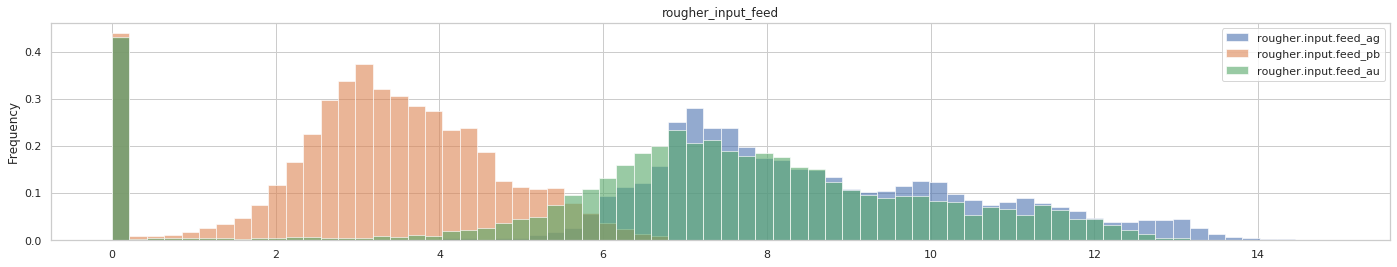

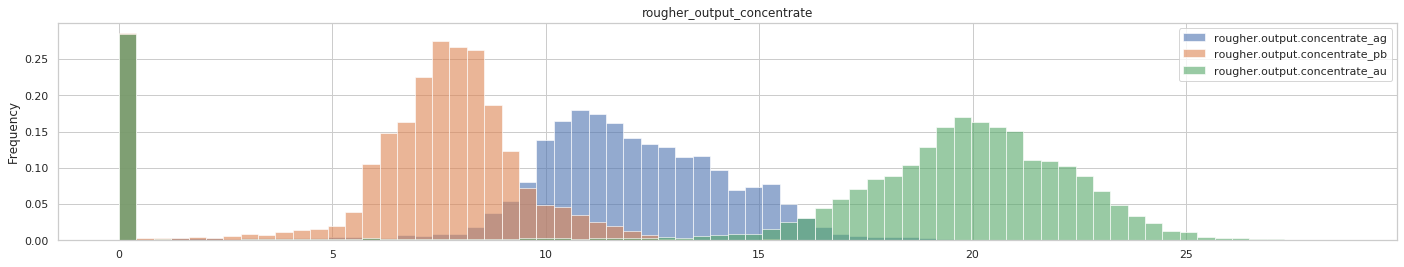

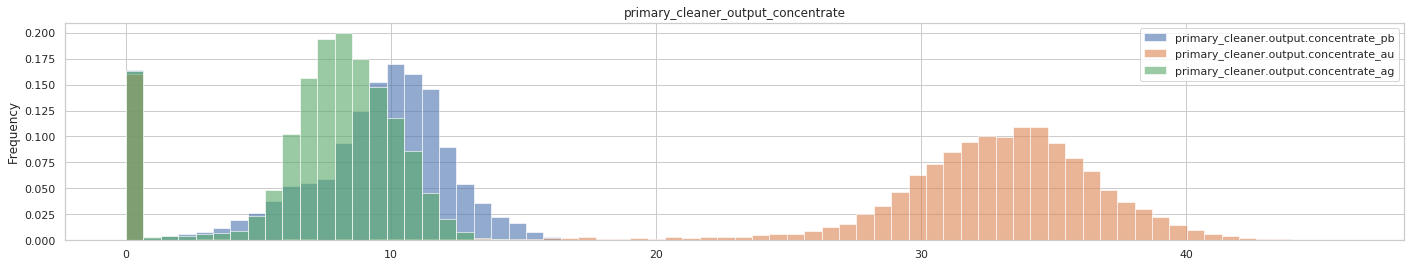

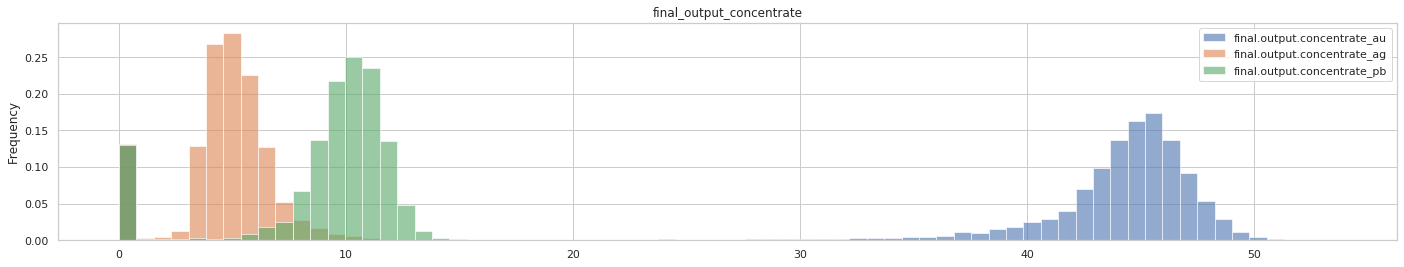

In [54]:
def plt_f(df, name):
    df.plot(kind='hist',
            bins=70,
            density=True,
            figsize=(24,4),
            grid=True,
            alpha = 0.6,
            title = name)
    
plt_f(rougher_input_feed, 'rougher_input_feed')
plt_f(rougher_output_concentrate, 'rougher_output_concentrate')
plt_f(primary_cleaner_output_concentrate, 'primary_cleaner_output_concentrate')
plt_f(final_output_concentrate, 'final_output_concentrate')

In [55]:
rougher_input_feed = train [{'rougher.input.feed_au',
                             'rougher.input.feed_ag',
                             'rougher.input.feed_pb'
                            }]

rougher_output_tail = train [{'rougher.output.tail_au',
                              'rougher.output.tail_ag',
                              'rougher.output.tail_pb'
                             }]

primary_cleaner_output_tail = train [{'primary_cleaner.output.tail_au',
                                      'primary_cleaner.output.tail_ag',
                                      'primary_cleaner.output.tail_pb'
                                     }]

final_output_tail = train [{'final.output.tail_au',
                            'final.output.tail_ag',
                            'final.output.tail_pb'
                           }]

display(rougher_input_feed.head())
display(rougher_output_tail.head())
display(primary_cleaner_output_tail.head())
display(final_output_tail.head())

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au
date,,,
2016-01-15 00:00:00,6.100378,2.284912,6.486150
2016-01-15 01:00:00,6.161113,2.266033,6.478583
2016-01-15 02:00:00,6.116455,2.159622,6.362222
2016-01-15 03:00:00,6.043309,2.037807,6.118189
2016-01-15 04:00:00,6.060915,1.786875,5.663707


,rougher.output.tail_au,rougher.output.tail_pb,rougher.output.tail_ag
date,,,
2016-01-15 00:00:00,1.170244,0.508728,5.008018
2016-01-15 01:00:00,1.184827,0.536689,4.955378
2016-01-15 02:00:00,1.162562,0.546416,4.843460
2016-01-15 03:00:00,1.079755,0.542525,4.655288
2016-01-15 04:00:00,1.012642,0.515438,4.552800


,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag
date,,,
2016-01-15 00:00:00,2.534912,2.106679,14.936526
2016-01-15 01:00:00,3.049646,2.353017,16.250511
2016-01-15 02:00:00,3.124664,2.416800,16.491823
2016-01-15 03:00:00,2.960362,2.262051,16.024359
2016-01-15 04:00:00,3.112100,2.277073,16.480185


,final.output.tail_au,final.output.tail_ag,final.output.tail_pb
date,,,
2016-01-15 00:00:00,2.143149,10.411962,0.895447
2016-01-15 01:00:00,2.224930,10.462676,0.927452
2016-01-15 02:00:00,2.257889,10.507046,0.953716
2016-01-15 03:00:00,2.146849,10.422762,0.883763
2016-01-15 04:00:00,2.055292,10.360302,0.792826


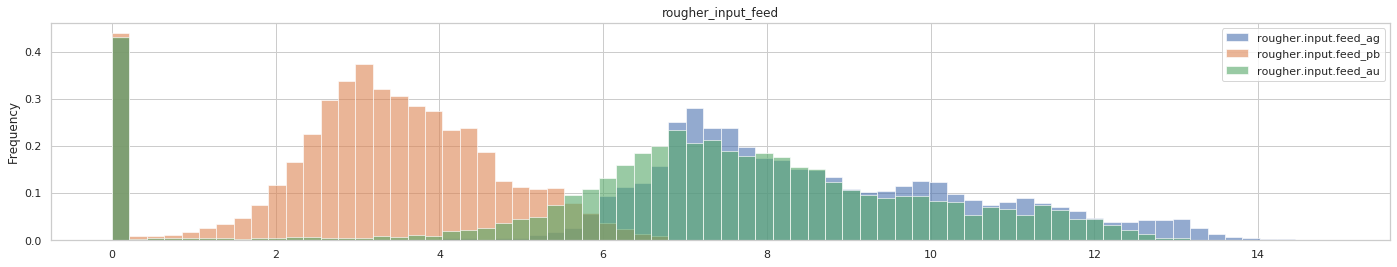

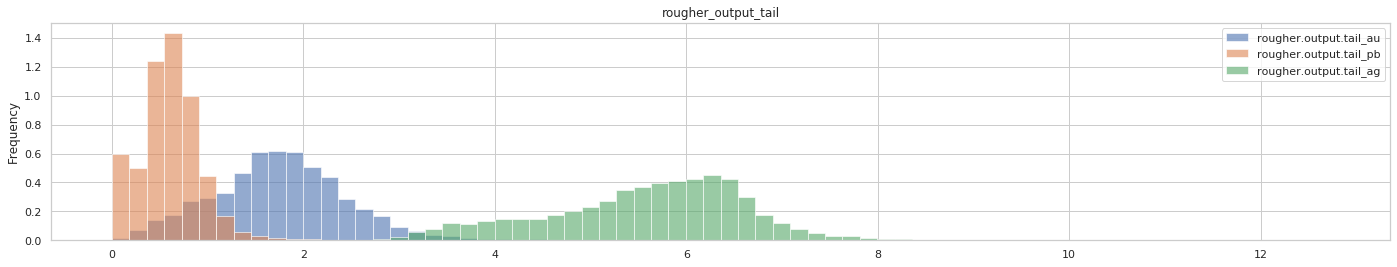

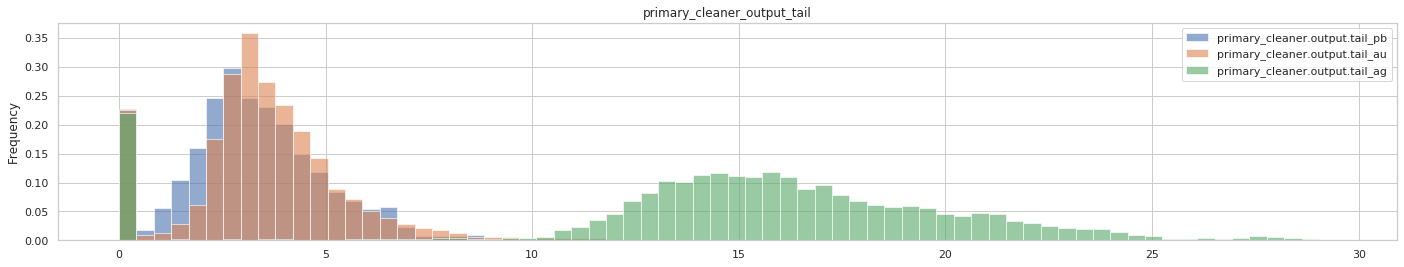

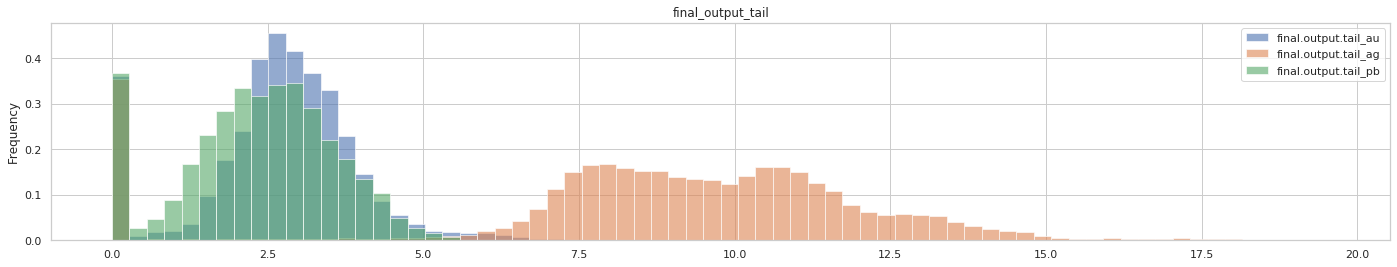

In [56]:
plt_f(rougher_input_feed, 'rougher_input_feed')
plt_f(rougher_output_tail, 'rougher_output_tail')
plt_f(primary_cleaner_output_tail, 'primary_cleaner_output_tail')
plt_f(final_output_tail, 'final_output_tail')

Концетрация золота увеличивается в процессе обработки, хвосты уменьшаются

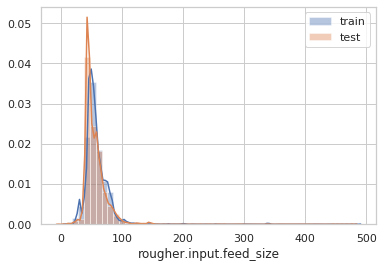

In [57]:
sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

распределения размера гранул сырья в трейне и в тесте очень похожи

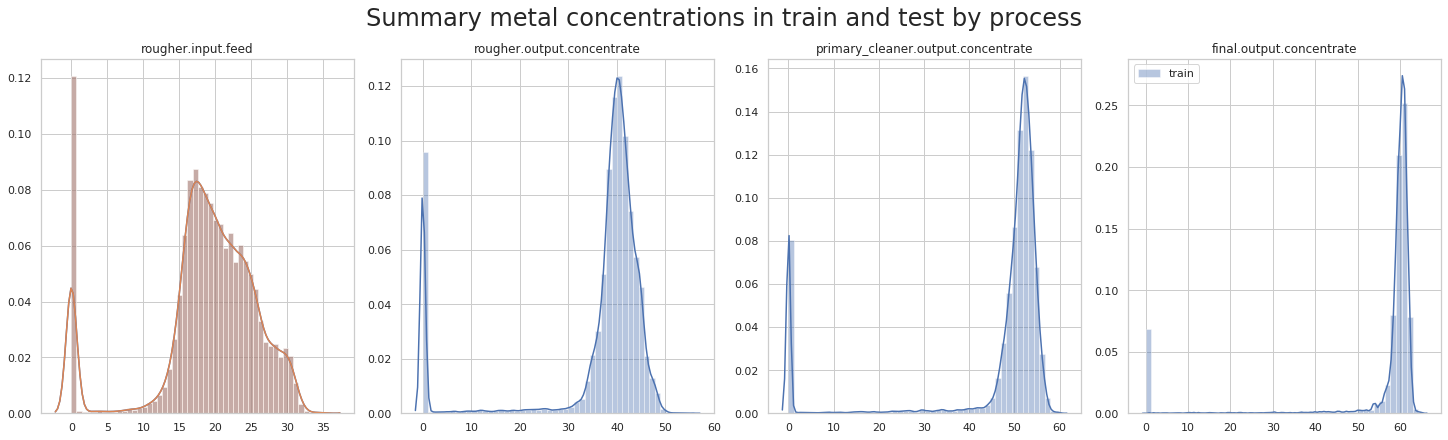

In [58]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']


fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Summary metal concentrations in train and test by process', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    sum_train = train_root_in_full[stage+ '_ag'] + train_root_in_full[stage+ '_au'] + train_root_in_full[stage+ '_pb']
    try:
        sum_test = test_in_full[stage+ '_ag'] + test_in_full[stage+ '_au'] + test_in_full[stage+ '_pb']
        sns.distplot(sum_test.dropna(), label='test', ax=ax) 
    except KeyError:
        pass
    sns.distplot(sum_train.dropna(), label='train', ax=ax) 

plt.legend()
plt.show()

Выбросы есть, но это реальность, а модель мы готовим к реальной жизни, поэтому чистить выбросы мы не будем

# 3. Модель

### 3.1. Напишем функцию для вычисления итоговой sMAPE.

In [59]:
def smape(target,pred):
    return np.mean(200*np.abs(target-pred)/(np.abs(target)+np.abs(pred)))

In [60]:
def final_smape(smape_rougher, smape_final):
    return 0.25* smape_rougher + 0.75*smape_final

In [61]:
custom_scorer = make_scorer(smape, greater_is_better = False)

### 3.2. Обучим разные модели и оценим их качество кросс-валидацией.

Мы не будем брать данные, которые шли для подсчета Флотации и которые нужны для подсчета второгр целевого признака. Это как дерево данных, нам не нужны данные на входе флотации, потому что из них уже все нужное забрали, получив данные выхода флотации

Столбца, которые нужны для подсчета первого целевого признака
**rougher.output.recovery**


## Sage_1 :

In [62]:
Sage_1_columns = ['rougher.input.feed_pb',
                  'rougher.input.feed_rate',
                  'rougher.input.feed_size',
                  'rougher.input.feed_sol',
                  'rougher.input.feed_au',
                  'rougher.input.floatbank10_sulfate',
                  'rougher.input.floatbank10_xanthate',
                  'rougher.input.floatbank11_sulfate',
                  'rougher.input.floatbank11_xanthate',
                  'rougher.output.recovery',
                  'rougher.state.floatbank10_a_air',
                  'rougher.state.floatbank10_a_level',
                  'rougher.state.floatbank10_b_air',
                  'rougher.state.floatbank10_b_level',
                  'rougher.state.floatbank10_c_air',
                  'rougher.state.floatbank10_c_level',
                  'rougher.state.floatbank10_d_air',
                  'rougher.state.floatbank10_d_level',
                  'rougher.state.floatbank10_e_air',
                  'rougher.state.floatbank10_e_level',
                  'rougher.state.floatbank10_f_air',
                  'rougher.state.floatbank10_f_level'
                 ]

In [63]:
Sage_1 = prepared_full[Sage_1_columns]
display(Sage_1.head(3))
display(Sage_1.info())

,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,87.107763,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
2016-01-15 01:00:00,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,86.843261,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2016-01-15 02:00:00,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,86.842308,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 22 columns):
rougher.input.feed_pb                 19439 non-null float64
rougher.input.feed_rate               19439 non-null float64
rougher.input.feed_size               19439 non-null float64
rougher.input.feed_sol                19439 non-null float64
rougher.input.feed_au                 19439 non-null float64
rougher.input.floatbank10_sulfate     19439 non-null float64
rougher.input.floatbank10_xanthate    19439 non-null float64
rougher.input.floatbank11_sulfate     19439 non-null float64
rougher.input.floatbank11_xanthate    19439 non-null float64
rougher.output.recovery               19439 non-null float64
rougher.state.floatbank10_a_air       19439 non-null float64
rougher.state.floatbank10_a_level     19439 non-null float64
rougher.state.floatbank10_b_air       19439 non-null float64
rougher.state.floatbank10_b_level     19439 non-null float64
ro

None

---

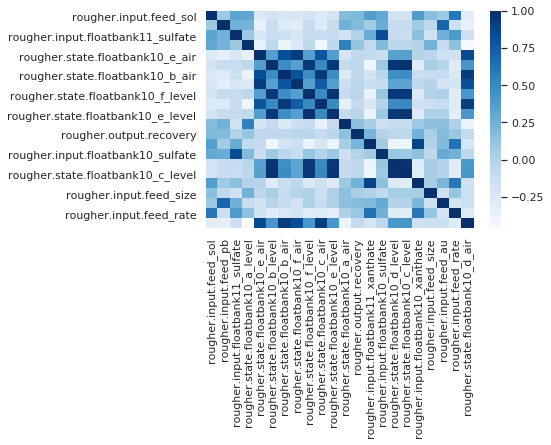

In [64]:
# `pairplot()` may become very slow with the SVG format
%config InlineBackend.figure_format = 'png' 
# Drop non-numerical variables
numericalq = list(set(Sage_1.columns))
plt.figure()
# Calculate and plot
corr_matrixq = Sage_1[numericalq].corr()
sns.heatmap(corr_matrixq, cmap="Blues")

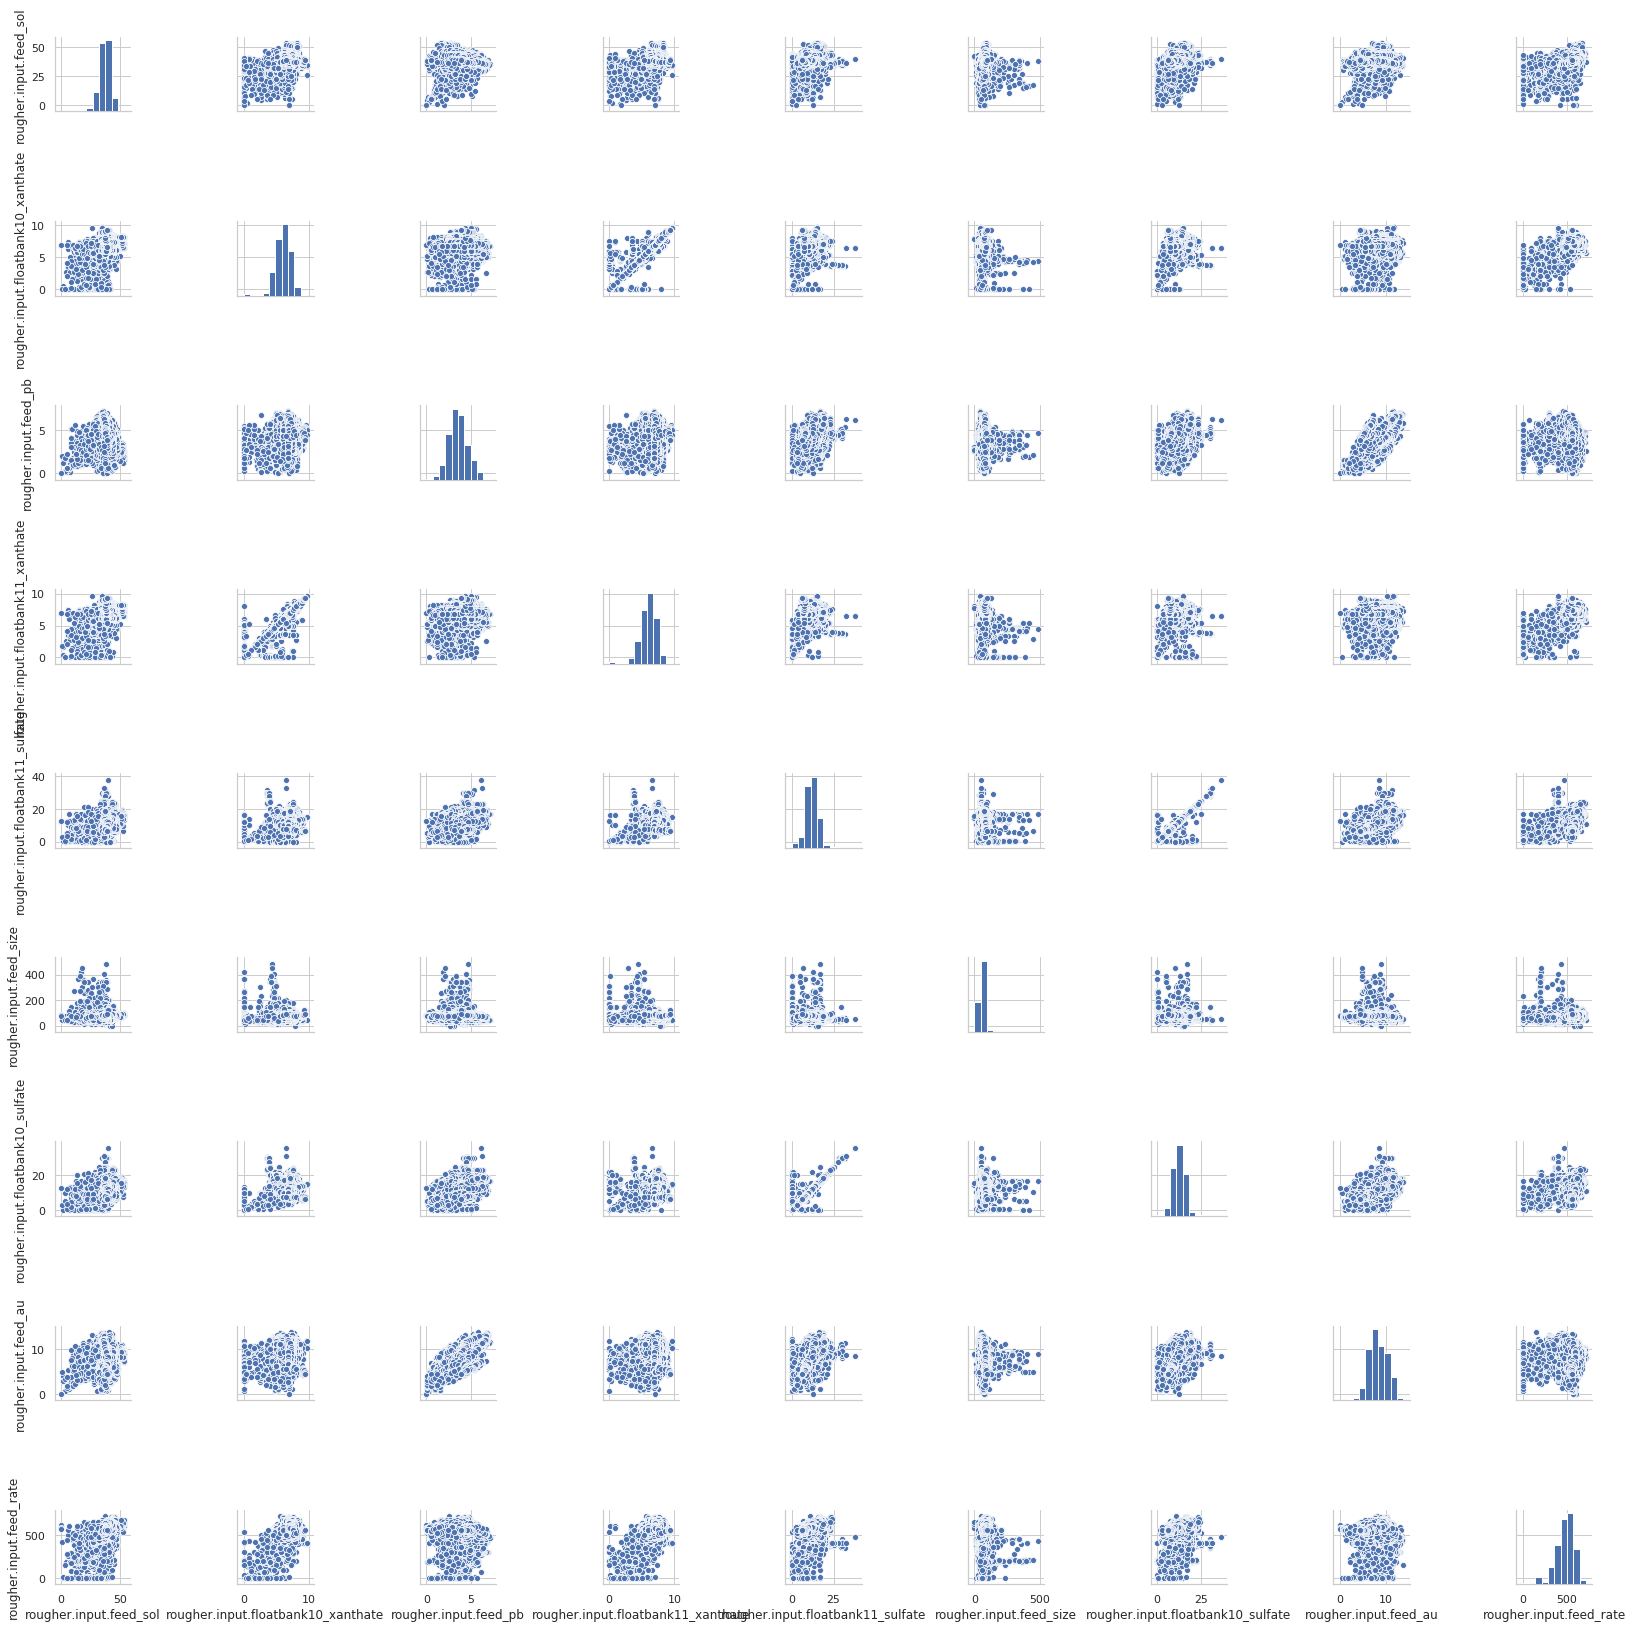

In [65]:
sns.pairplot(Sage_1[{'rougher.input.feed_pb',
                  'rougher.input.feed_rate',
                  'rougher.input.feed_size',
                  'rougher.input.feed_sol',
                  'rougher.input.feed_au',
                  'rougher.input.floatbank10_sulfate',
                  'rougher.input.floatbank10_xanthate',
                  'rougher.input.floatbank11_sulfate',
                  'rougher.input.floatbank11_xanthate'
                   }])
# plt.suptitle('***'*20 ,'Sage_1', '***'*20)

Можем заметить частую линейную зависимость между некоторыми данными, а так же шумы и кластеры

---

Разделим на X ,y

In [66]:
X = Sage_1.drop('rougher.output.recovery', axis=1)
y = Sage_1['rougher.output.recovery']

**LinearRegression**

In [67]:
param_grid_logres = {'fit_intercept':['True','False'],
                     'normalize':['True','False'],
                    }

In [68]:
# logres_Sage_1 = GridSearchCV(LinearRegression(), param_grid = param_grid_logres)
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [69]:
# logres_Sage_1.fit(X, y)

In [70]:
# logres_Sage_1.best_params_

In [71]:
model_logres_Sage_1 = LinearRegression(fit_intercept=True, normalize=True)

кросс-валидация и посчитаем sMAPE

In [72]:
cv_logres = cross_val_score(model_logres_Sage_1,
                            X,
                            y,
                            cv=3,
                            scoring = custom_scorer)
final_score_logres_Sage_1  = np.abs(sum(cv_logres) / len(cv_logres))
final_score_logres_Sage_1 

12.998087607736663

**DecisionTreeRegressor**

In [73]:
param_grid_dt = {'max_depth':[depth for depth in range(1,6)],
                 'min_samples_split':[split for split in range(2,7,1)],
                 'min_samples_leaf':[leaf for leaf in range(1,7,1)]
                }

In [74]:
# dt_Sage_1 = GridSearchCV(RandomForestRegressor(), param_grid = param_grid_rf)

In [75]:
# dt_Sage_1.fit(X, y)

In [76]:
# dt_Sage_1.best_params_

In [77]:
model_dt_Sage_1 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=6, min_samples_split= 6,random_state=12345)

In [78]:
cv_dt = cross_val_score(model_dt_Sage_1,
                        X,
                        y,
                        cv=3,
                        scoring = custom_scorer)
final_score_dt_Sage_1 = np.abs(sum(cv_dt) / len(cv_dt))
final_score_dt_Sage_1

12.192714523272116

**RandomForestRegressor**

In [79]:
param_grid_rf = {'n_estimators': [n_estim for n_estim in range(50,100,10)],
                 'max_depth': [depth for depth in range(1,6,1)],
                 'min_samples_leaf':[leaf for leaf in range(1,6,1)]
                }

In [80]:
# rf_Sage_1 = GridSearchCV(RandomForestRegressor(), param_grid = param_grid_rf)


In [81]:
# rf_Sage_1.fit(X, y)

In [82]:
# rf_Sage_1.best_params_

In [83]:
model_rf_Sage_1 = RandomForestRegressor(random_state=12345,
                                          max_depth=4,
                                          min_samples_leaf=3,
                                          n_estimators=60
                                         )

In [84]:
cv_rf = cross_val_score(model_rf_Sage_1,
                        X,
                        y,
                        cv=3,
                        scoring = custom_scorer)
final_score_rf_Sage_1 = np.abs(sum(cv_rf) / len(cv_rf))
final_score_rf_Sage_1

12.11953628050412

Второй признак будет предсказывать так: возьмем предсказания на Stage_1 и необходимые данные для конкретного технологического процесса. Данные о входе на Флотацию и Sage_1 нам только помешают.

## Sage_2 :

In [85]:
Stage_2_columns = ['primary_cleaner.input.sulfate',
                   'primary_cleaner.input.depressant',
                   'primary_cleaner.input.feed_size',
                   'primary_cleaner.input.xanthate',
                   'primary_cleaner.state.floatbank8_a_air',
                   'primary_cleaner.state.floatbank8_a_level',
                   'primary_cleaner.state.floatbank8_b_air',
                   'primary_cleaner.state.floatbank8_b_level',
                   'primary_cleaner.state.floatbank8_c_air',
                   'primary_cleaner.state.floatbank8_c_level',
                   'primary_cleaner.state.floatbank8_d_air',
                   'primary_cleaner.state.floatbank8_d_level',
                   'secondary_cleaner.state.floatbank2_a_air',
                   'secondary_cleaner.state.floatbank2_a_level',
                   'secondary_cleaner.state.floatbank2_b_air',
                   'secondary_cleaner.state.floatbank2_b_level',
                   'secondary_cleaner.state.floatbank3_a_air',
                   'secondary_cleaner.state.floatbank3_a_level',
                   'secondary_cleaner.state.floatbank3_b_air',
                   'secondary_cleaner.state.floatbank3_b_level',
                   'secondary_cleaner.state.floatbank4_a_air',
                   'secondary_cleaner.state.floatbank4_a_level',
                   'secondary_cleaner.state.floatbank4_b_air',
                   'secondary_cleaner.state.floatbank4_b_level',
                   'secondary_cleaner.state.floatbank5_a_air',
                   'secondary_cleaner.state.floatbank5_a_level',
                   'secondary_cleaner.state.floatbank5_b_air',
                   'secondary_cleaner.state.floatbank5_b_level',
                   'secondary_cleaner.state.floatbank6_a_air',
                   'secondary_cleaner.state.floatbank6_a_level',
                   'final.output.recovery'
                  ]

In [86]:
Sage_2 = prepared_full[Stage_2_columns]
display(Sage_2.head(3))
display(Sage_2.info())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,70.541216
2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,69.266198
2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,68.116445


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 31 columns):
primary_cleaner.input.sulfate                 19439 non-null float64
primary_cleaner.input.depressant              19439 non-null float64
primary_cleaner.input.feed_size               19439 non-null float64
primary_cleaner.input.xanthate                19439 non-null float64
primary_cleaner.state.floatbank8_a_air        19439 non-null float64
primary_cleaner.state.floatbank8_a_level      19439 non-null float64
primary_cleaner.state.floatbank8_b_air        19439 non-null float64
primary_cleaner.state.floatbank8_b_level      19439 non-null float64
primary_cleaner.state.floatbank8_c_air        19439 non-null float64
primary_cleaner.state.floatbank8_c_level      19439 non-null float64
primary_cleaner.state.floatbank8_d_air        19439 non-null float64
primary_cleaner.state.floatbank8_d_level      19439 non-null float64
secondary_cleaner.state.floa

None

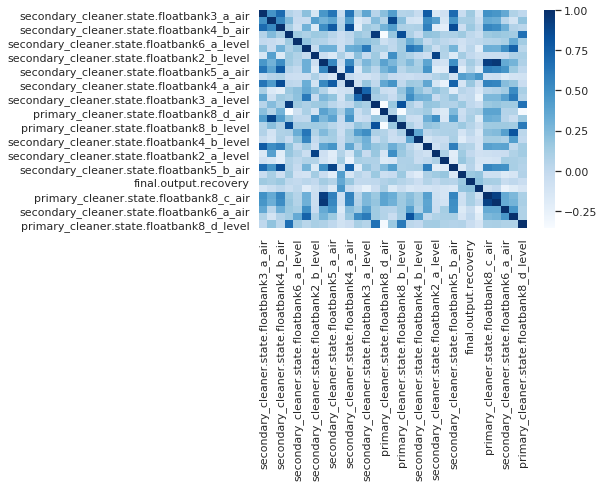

In [87]:
# `pairplot()` may become very slow with the SVG format
%config InlineBackend.figure_format = 'png' 
# Drop non-numerical variables
numericalq = list(set(Sage_2.columns))
plt.figure()
# Calculate and plot
corr_matrixq = Sage_2[numericalq].corr()
sns.heatmap(corr_matrixq, cmap="Blues")

In [89]:
model_rf_Sage_1.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [90]:
predict_Sage_1 = model_rf_Sage_1.predict(X)

In [91]:
Sage_2['rougher.output.recovery'] = predict_Sage_1
X_2 = Sage_2.drop('final.output.recovery', axis=1)

In [92]:
y_2 = Sage_2['final.output.recovery']

**LinearRegression**

In [93]:
param_grid_logres = {'fit_intercept':['True','False'],
                     'normalize':['True','False'],
                    }

In [94]:
# logres_Sage_2 = GridSearchCV(LinearRegression(), param_grid = param_grid_logres)
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [95]:
# logres_Sage_2.fit(X_2, y)

In [96]:
# logres_Sage_2.best_params_

In [97]:
model_logres_Sage_2 = LinearRegression(fit_intercept=True, normalize=True)

кросс-валидация и посчитаем sMAPE

In [98]:
cv_logres = cross_val_score(model_logres_Sage_2,
                            X_2,
                            y_2,
                            cv=3,
                            scoring = custom_scorer)
final_score_logres_Sage_2  = np.abs(sum(cv_logres) / len(cv_logres))
final_score_logres_Sage_2 

11.034751646217769

**DecisionTreeRegressor**

In [99]:
param_grid_dt = {'max_depth':[depth for depth in range(1,6)],
                 'min_samples_split':[split for split in range(2,7,1)],
                 'min_samples_leaf':[leaf for leaf in range(1,7,1)]
                }

In [100]:
# dt_Sage_2 = GridSearchCV(RandomForestRegressor(), param_grid = param_grid_rf)

In [101]:
# dt_Sage_2.fit(X_2, y_2)

In [102]:
# dt_Sage_1.best_params_

In [103]:
model_dt_Sage_2 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=6, min_samples_split= 6,random_state=12345)

In [104]:
cv_dt = cross_val_score(model_dt_Sage_2,
                        X_2,
                        y_2,
                        cv=3,
                        scoring = custom_scorer)
final_score_dt_Sage_2 = np.abs(sum(cv_dt) / len(cv_dt))
final_score_dt_Sage_2

11.289701484752923

**RandomForestRegressor**

In [105]:
param_grid_rf = {'n_estimators': [n_estim for n_estim in range(50,100,10)],
                 'max_depth': [depth for depth in range(1,6,1)],
                 'min_samples_leaf':[leaf for leaf in range(1,6,1)]
                }

In [106]:
# rf_Sage_2 = GridSearchCV(RandomForestRegressor(), param_grid = param_grid_rf)


In [107]:
# rf_Sage_2.fit(X_2, y_2)

In [108]:
# rf_Sage_2.best_params_

In [109]:
model_rf_Sage_2 = RandomForestRegressor(random_state=12345,
                                          max_depth=4,
                                          min_samples_leaf=3,
                                          n_estimators=60
                                         )

In [110]:
cv_rf = cross_val_score(model_rf_Sage_2,
                        X_2,
                        y_2,
                        cv=3,
                        scoring = custom_scorer)
final_score_rf_Sage_2 = np.abs(sum(cv_rf) / len(cv_rf))
final_score_rf_Sage_2

10.701816451875134

| Этаа   | модель                 | sMAPE           |
---------|-----------------------|------------------|
| Sage_1:| RandomForestRegressor | 12.11953628050412|
| Sage_2:| RandomForestRegressor | 10.70181645187513|

# Тестирование

### Sage_1

In [111]:
test_Sage = prepared_full.query('index in @test.index')
test_Sage_1= test_Sage[Sage_1_columns]

In [112]:
X_test_Sage_1 = test_Sage_1.drop('rougher.output.recovery', axis=1)
y_test_Sage_1 = test_Sage['rougher.output.recovery']

In [113]:
model_rf_Sage_1.fit(X_test_Sage_1,y_test_Sage_1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [114]:
predict_test_Sage_1 = model_rf_Sage_1.predict(X_test_Sage_1)

sMAPE

In [115]:
test_smape_Sage_1 = smape(y_test_Sage_1,predict_test_Sage_1)
test_smape_Sage_1

7.618193652699778

### Sage_2

In [116]:
test_Sage_2 = test_Sage[Stage_2_columns]
test_Sage_2['rougher.output.recovery'] = predict_test_Sage_1

In [117]:
X_test_Sage_2 = test_Sage_2.drop('final.output.recovery', axis=1)
y_test_Sage_2 = test_Sage_2['final.output.recovery']

In [118]:
model_rf_Sage_2.fit(X_test_Sage_2,y_test_Sage_2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [119]:
predict_test_Sage_2 = model_rf_Sage_2.predict(X_test_Sage_2)

sMAPE

In [120]:
test_smape_Sage_2 = smape(y_test_Sage_2,predict_test_Sage_2)
test_smape_Sage_2

8.041854506386228

### итоговое sMAPE

In [121]:
final_smape(test_smape_Sage_1,test_smape_Sage_2)

7.9359392929646155

### Сравнение с константой

In [122]:
Sage_1_konst = pd.Series(y_test_Sage_1.mean(),y_test_Sage_1.index)

In [123]:
smape_Sage_1_konst = smape(y_test_Sage_1,Sage_1_konst)
smape_Sage_1_konst

8.782646809148405

In [124]:
Sage_2_konst = pd.Series(y_test_Sage_2.mean(),y_test_Sage_2.index)

In [125]:
smape_Sage_2_konst = smape(y_test_Sage_2,Sage_2_konst)
smape_Sage_2_konst

9.370995594347834

In [126]:
final_smape(smape_Sage_1_konst,smape_Sage_2_konst)

9.223908398047977

Наши модели справились)